<a href="https://colab.research.google.com/github/cheyoung211/2023-Auttum-Maths-for-ML/blob/main/vae_202102779_%EC%9D%B4%EC%B2%B4%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👖 변이형 오토인코더 - 패션 MNIST

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/02_vae_fashion/vae_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

이 노트북에서는 패션 MNIST 데이터셋으로 변이형 오토인코더를 훈련합니다.

In [ ]:
import sys

if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2023-11-14 11:21:25--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-11-14 11:21:25 (64.9 MB/s) - ‘utils.py’ saved [771/771]



이 코드는 케라스 웹 사이트에 있는 프랑소와 숄레(Francois Chollet)가 만든 훌륭한 [VAE 튜토리얼](https://keras.io/examples/generative/vae/)을 참고했습니다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

from notebooks.utils import display

## 0. 파라미터 <a name="parameters"></a>

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 20
BETA = 500

## 1. 데이터 준비 <a name="prepare"></a>

In [ ]:
# mnist데이터 로드
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [ ]:
# 데이터 전처리
def preprocess(imgs):
    """
    이미지 정규화 및 크기 변경
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

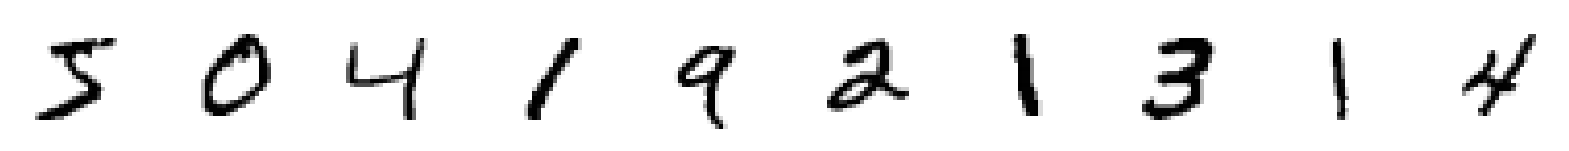

In [ ]:
# training data 일부 보여주기
display(x_train)

## 2. 변이형 오토인코더 만들기 <a name="build"></a>

In [ ]:
#샘플링할 class 생성
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # 디코더에 필요합니다!

x = layers.Flatten()(x)
#잠재 공간
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])


In [ ]:
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
#인코더 요약
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_4[0][0]']            
                                                                                            

In [ ]:
# decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input") #embedding
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)


In [ ]:
decoder = models.Model(decoder_input, decoder_output)
#디코더 요약
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 32)        1846

In [ ]:
#VAE class 생성
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder #인코더
        self.decoder = decoder #디코더
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """특정 입력에서 모델을 호출합니다."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """훈련 스텝을 실행합니다."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
# 변이형 오토인코더 생성 - 인코더와 디코더 연결
vae = VAE(encoder, decoder)

## 3. 변이형 오토인코더 훈련 <a name="train"></a>

In [ ]:
# 변이형 오토인코더 컴파일
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss = 'binary_crossentropy')

In [ ]:
# 모델 저장 체크포인트 생성
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/20
595/600 [============================>.] - ETA: 0s - total_loss: 104.3624 - reconstruction_loss: 101.2757 - kl_loss: 3.0867

600/600 [==============================] - 9s 11ms/step - total_loss: 104.1890 - reconstruction_loss: 101.0977 - kl_loss: 3.0913 - val_loss: 83.8669 - val_reconstruction_loss: 80.2211 - val_kl_loss: 3.6458
Epoch 2/20
597/600 [============================>.] - ETA: 0s - total_loss: 82.9840 - reconstruction_loss: 79.0437 - kl_loss: 3.9403

600/600 [==============================] - 6s 10ms/step - total_loss: 82.9817 - reconstruction_loss: 79.0405 - kl_loss: 3.9412 - val_loss: 79.0176 - val_reconstruction_loss: 74.9130 - val_kl_loss: 4.1046
Epoch 3/20
597/600 [============================>.] - ETA: 0s - total_loss: 80.6233 - reconstruction_loss: 76.2890 - kl_loss: 4.3342

600/600 [==============================] - 6s 10ms/step - total_loss: 80.6217 - reconstruction_loss: 76.2865 - kl_loss: 4.3351 - val_loss: 78.1080 - val_reconstruction_loss: 73.7698 - val_kl_loss: 4.3382
Epoch 4/20
596/600 [============================>.] - ETA: 0s - total_loss: 79.3068 - reconstruction_loss: 74.7633 - kl_loss: 4.5435

600/600 [==============================] - 6s 10ms/step - total_loss: 79.2927 - reconstruction_loss: 74.7511 - kl_loss: 4.5417 - val_loss: 76.9973 - val_reconstruction_loss: 72.4865 - val_kl_loss: 4.5108
Epoch 5/20
599/600 [============================>.] - ETA: 0s - total_loss: 78.4064 - reconstruction_loss: 73.7146 - kl_loss: 4.6919

600/600 [==============================] - 6s 10ms/step - total_loss: 78.4098 - reconstruction_loss: 73.7175 - kl_loss: 4.6923 - val_loss: 77.3976 - val_reconstruction_loss: 72.3676 - val_kl_loss: 5.0300
Epoch 6/20
597/600 [============================>.] - ETA: 0s - total_loss: 77.7768 - reconstruction_loss: 72.9757 - kl_loss: 4.8012

600/600 [==============================] - 6s 10ms/step - total_loss: 77.7737 - reconstruction_loss: 72.9726 - kl_loss: 4.8011 - val_loss: 76.9468 - val_reconstruction_loss: 72.1720 - val_kl_loss: 4.7748
Epoch 7/20
597/600 [============================>.] - ETA: 0s - total_loss: 77.2119 - reconstruction_loss: 72.3315 - kl_loss: 4.8805

600/600 [==============================] - 6s 10ms/step - total_loss: 77.2104 - reconstruction_loss: 72.3300 - kl_loss: 4.8804 - val_loss: 75.9010 - val_reconstruction_loss: 70.9233 - val_kl_loss: 4.9777
Epoch 8/20
599/600 [============================>.] - ETA: 0s - total_loss: 76.7877 - reconstruction_loss: 71.8258 - kl_loss: 4.9619

600/600 [==============================] - 6s 10ms/step - total_loss: 76.7802 - reconstruction_loss: 71.8178 - kl_loss: 4.9624 - val_loss: 75.7589 - val_reconstruction_loss: 70.5361 - val_kl_loss: 5.2228
Epoch 9/20
598/600 [============================>.] - ETA: 0s - total_loss: 76.4211 - reconstruction_loss: 71.4021 - kl_loss: 5.0190

600/600 [==============================] - 6s 11ms/step - total_loss: 76.4230 - reconstruction_loss: 71.4044 - kl_loss: 5.0186 - val_loss: 75.7781 - val_reconstruction_loss: 70.7761 - val_kl_loss: 5.0020
Epoch 10/20
599/600 [============================>.] - ETA: 0s - total_loss: 76.1063 - reconstruction_loss: 71.0375 - kl_loss: 5.0688

600/600 [==============================] - 6s 10ms/step - total_loss: 76.1055 - reconstruction_loss: 71.0367 - kl_loss: 5.0688 - val_loss: 75.7108 - val_reconstruction_loss: 70.6079 - val_kl_loss: 5.1029
Epoch 11/20
595/600 [============================>.] - ETA: 0s - total_loss: 75.8548 - reconstruction_loss: 70.7380 - kl_loss: 5.1169

600/600 [==============================] - 6s 11ms/step - total_loss: 75.8505 - reconstruction_loss: 70.7329 - kl_loss: 5.1176 - val_loss: 75.0538 - val_reconstruction_loss: 69.8485 - val_kl_loss: 5.2053
Epoch 12/20
600/600 [==============================] - ETA: 0s - total_loss: 75.5931 - reconstruction_loss: 70.4363 - kl_loss: 5.1570

600/600 [==============================] - 6s 11ms/step - total_loss: 75.5931 - reconstruction_loss: 70.4363 - kl_loss: 5.1570 - val_loss: 75.6761 - val_reconstruction_loss: 70.2842 - val_kl_loss: 5.3919
Epoch 13/20
598/600 [============================>.] - ETA: 0s - total_loss: 75.3814 - reconstruction_loss: 70.1855 - kl_loss: 5.1959

600/600 [==============================] - 6s 11ms/step - total_loss: 75.3802 - reconstruction_loss: 70.1840 - kl_loss: 5.1962 - val_loss: 74.7671 - val_reconstruction_loss: 69.4395 - val_kl_loss: 5.3276
Epoch 14/20
598/600 [============================>.] - ETA: 0s - total_loss: 75.1465 - reconstruction_loss: 69.9158 - kl_loss: 5.2307

600/600 [==============================] - 6s 10ms/step - total_loss: 75.1438 - reconstruction_loss: 69.9127 - kl_loss: 5.2312 - val_loss: 75.1278 - val_reconstruction_loss: 69.7477 - val_kl_loss: 5.3801
Epoch 15/20
600/600 [==============================] - ETA: 0s - total_loss: 74.9673 - reconstruction_loss: 69.7094 - kl_loss: 5.2580

600/600 [==============================] - 6s 11ms/step - total_loss: 74.9673 - reconstruction_loss: 69.7094 - kl_loss: 5.2580 - val_loss: 75.5269 - val_reconstruction_loss: 70.3361 - val_kl_loss: 5.1909
Epoch 16/20
599/600 [============================>.] - ETA: 0s - total_loss: 74.7960 - reconstruction_loss: 69.5159 - kl_loss: 5.2801

600/600 [==============================] - 6s 10ms/step - total_loss: 74.7898 - reconstruction_loss: 69.5099 - kl_loss: 5.2800 - val_loss: 74.6135 - val_reconstruction_loss: 69.3515 - val_kl_loss: 5.2620
Epoch 17/20
600/600 [==============================] - ETA: 0s - total_loss: 74.5734 - reconstruction_loss: 69.2671 - kl_loss: 5.3063

600/600 [==============================] - 6s 10ms/step - total_loss: 74.5734 - reconstruction_loss: 69.2671 - kl_loss: 5.3063 - val_loss: 75.2481 - val_reconstruction_loss: 69.8689 - val_kl_loss: 5.3792
Epoch 18/20
599/600 [============================>.] - ETA: 0s - total_loss: 74.5002 - reconstruction_loss: 69.1556 - kl_loss: 5.3446

600/600 [==============================] - 6s 11ms/step - total_loss: 74.4982 - reconstruction_loss: 69.1537 - kl_loss: 5.3445 - val_loss: 74.8946 - val_reconstruction_loss: 69.3936 - val_kl_loss: 5.5010
Epoch 19/20
597/600 [============================>.] - ETA: 0s - total_loss: 74.3248 - reconstruction_loss: 68.9693 - kl_loss: 5.3555

600/600 [==============================] - 6s 10ms/step - total_loss: 74.3162 - reconstruction_loss: 68.9614 - kl_loss: 5.3549 - val_loss: 74.6979 - val_reconstruction_loss: 69.3158 - val_kl_loss: 5.3820
Epoch 20/20
598/600 [============================>.] - ETA: 0s - total_loss: 74.1609 - reconstruction_loss: 68.7896 - kl_loss: 5.3712

600/600 [==============================] - 6s 10ms/step - total_loss: 74.1711 - reconstruction_loss: 68.8001 - kl_loss: 5.3710 - val_loss: 74.6656 - val_reconstruction_loss: 69.3175 - val_kl_loss: 5.3482


In [ ]:
# 최종 모델 저장
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 3. 변이형 오토인코더를 사용한 재구성 <a name="reconstruct"></a>

In [ ]:
# 테스트셋의 일부를 선택합니다.
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 1s 4ms/step
실제 손글씨


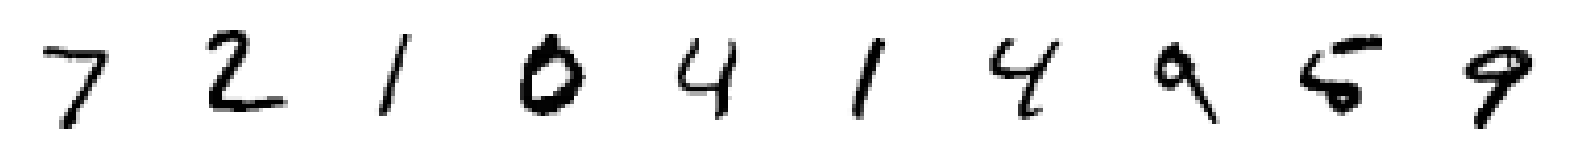

재구성 이미지


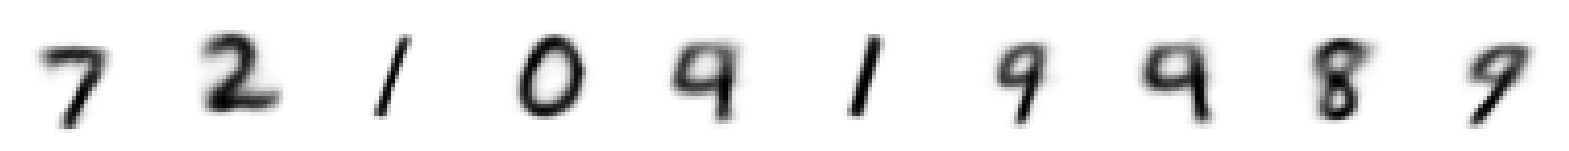

In [ ]:
# 오토인코더 예측을 만들고 출력합니다.
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("실제 손글씨")
display(example_images)
print("재구성 이미지")
display(reconstructions)

## 4. 인코더를 사용하여 임베딩하기 <a name="encode"></a>

In [ ]:
# 예제 이미지 인코딩
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [ ]:
# 임베딩의 몇 가지 예
print(z[:10])

[[ 0.5016435   1.6033126 ]
 [-1.4294991  -0.47748083]
 [ 2.8174987   0.79931456]
 [ 0.04984747 -1.5623279 ]
 [-1.2863406   0.85526955]
 [ 2.3155036   0.53096175]
 [ 0.02268983  0.8336169 ]
 [-1.6751615   1.0875456 ]
 [-0.51444983  0.28903294]
 [ 0.6834164   0.5892051 ]]


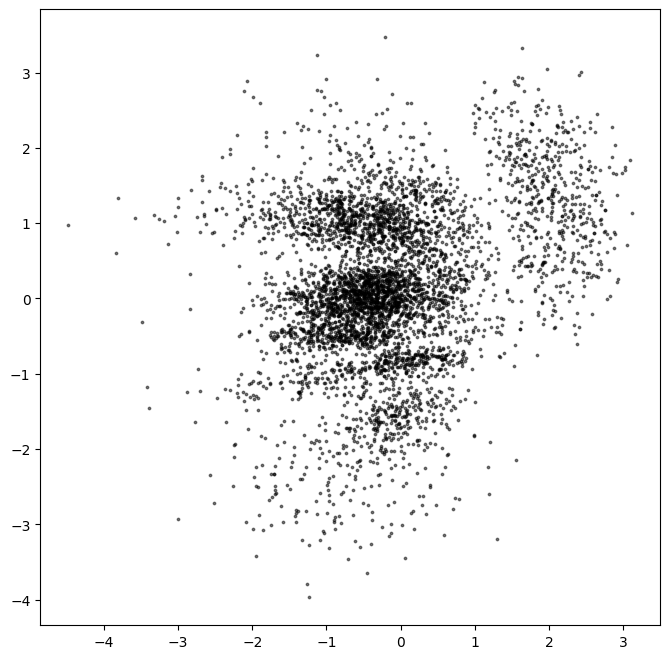

In [ ]:
# 잠재 공간에 임베딩 된 이미지의 산점도
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. 디코더를 사용하여 생성하기 <a name="decode"></a>

In [ ]:
# 표준 정규 분포에서 hidden layer의 일부 포인트를 sampling
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [ ]:
# 샘플링된 포인트 디코딩
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 104ms/step


In [ ]:
# 원본 임베딩과 샘플링된 임베딩을 p값으로 변환하기
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

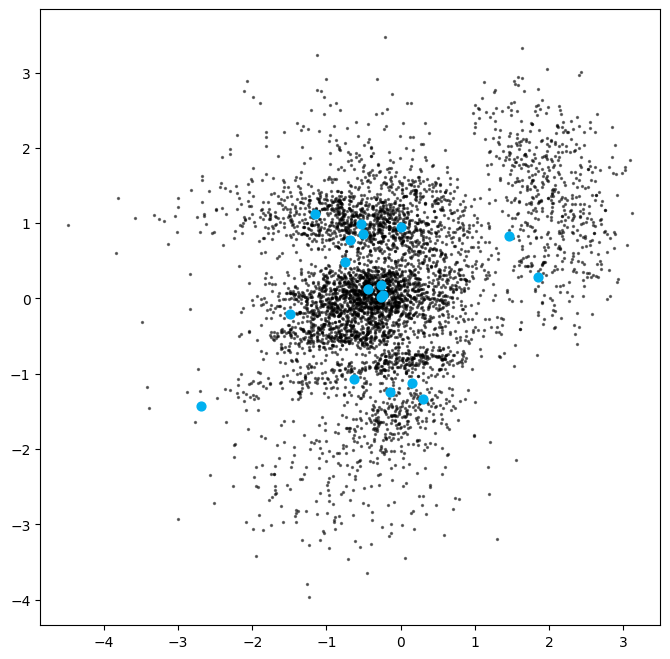

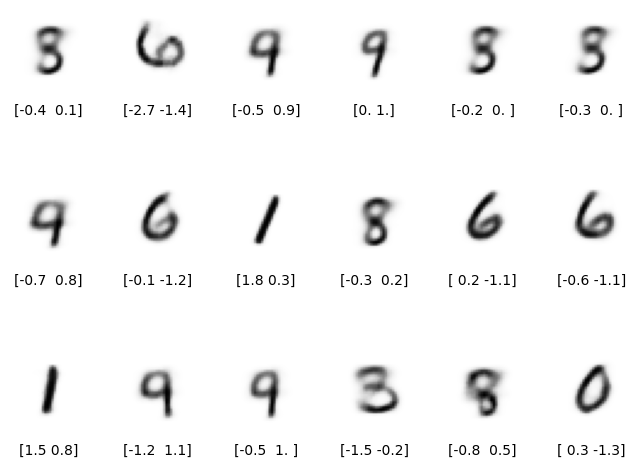

In [ ]:
# 그래프
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... 원본 임베딩 ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... 잠재 공간에 새로 생성된 포인트
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 디코딩된 이미지 그리드
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. 잠재 공간 탐색 <a name="explore"></a>

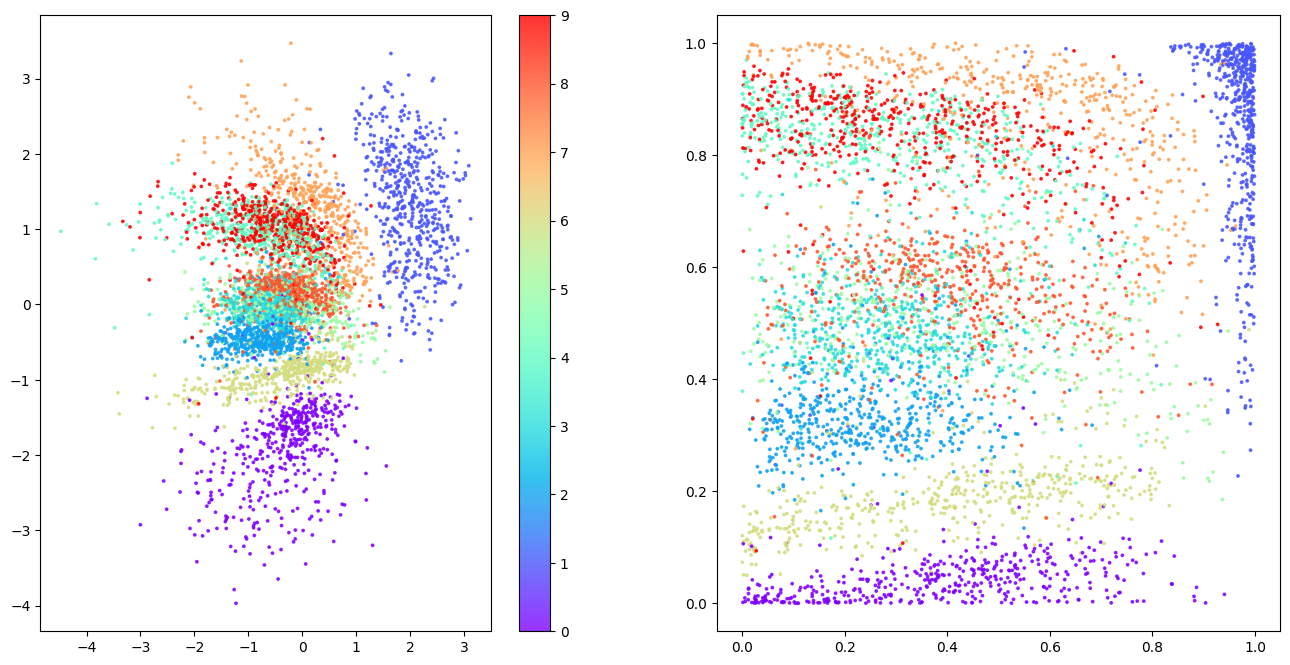

In [ ]:
# 레이블(숫자)에 따라 색상 지정
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

8/8 [==============================] - 0s 2ms/step


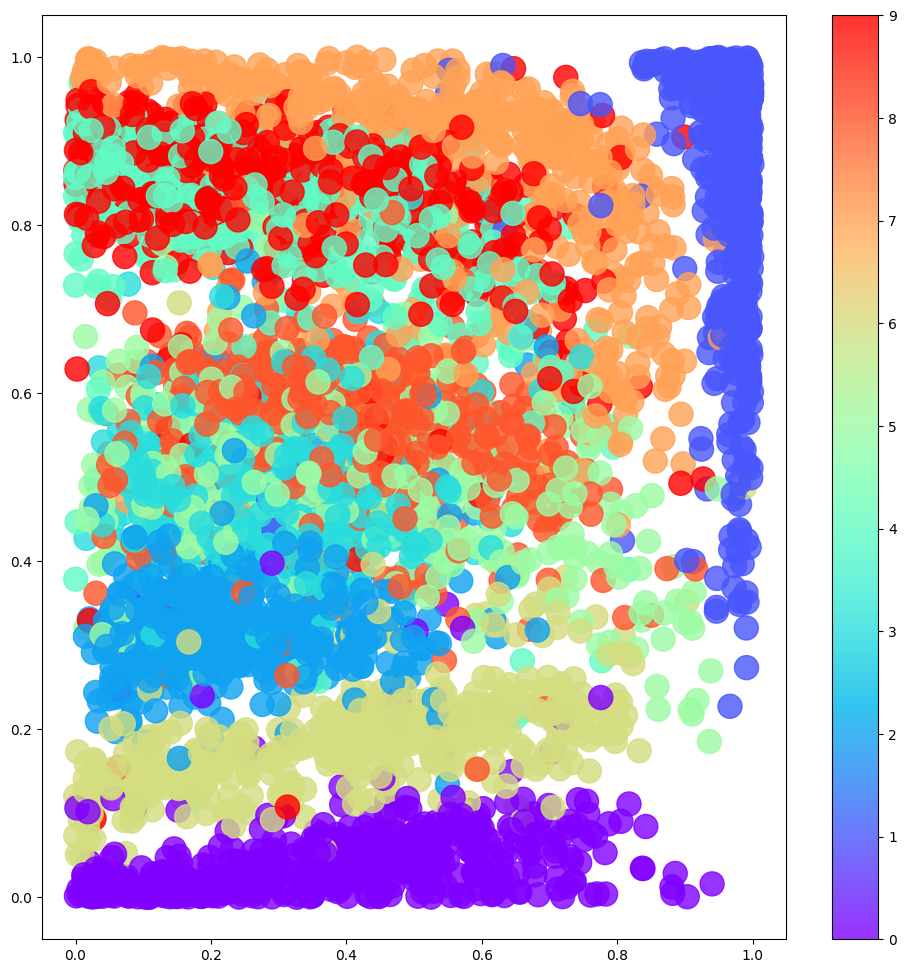

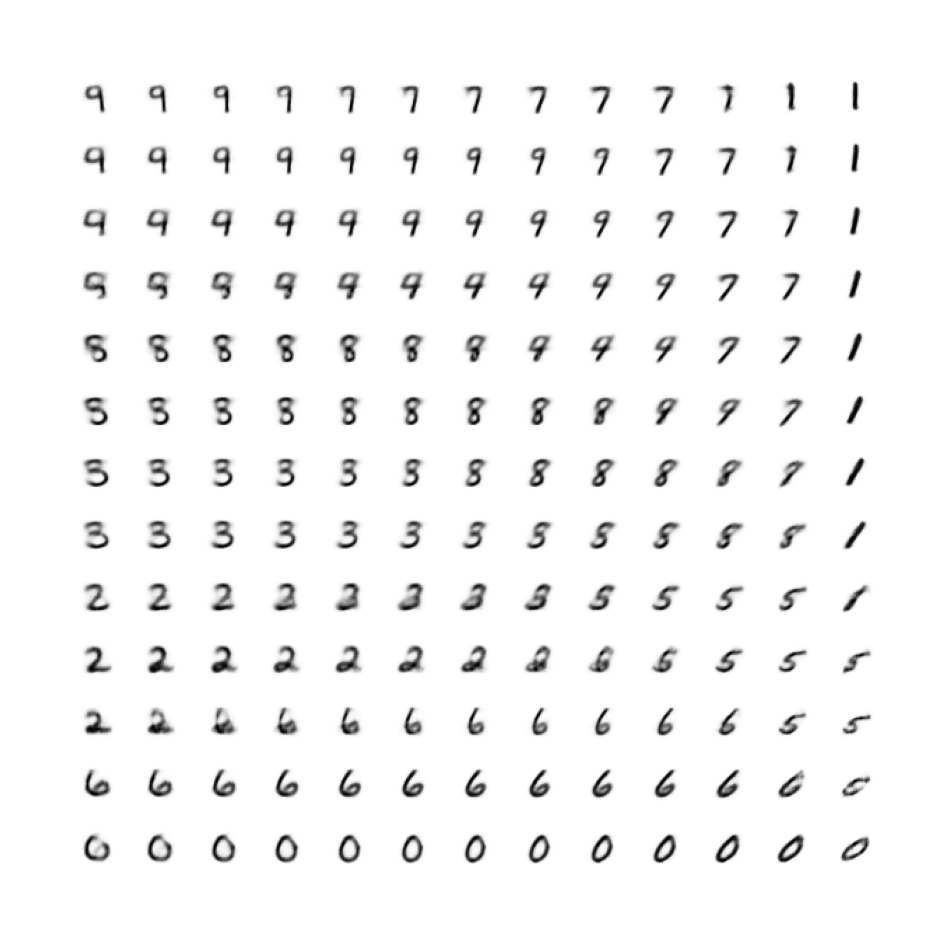

In [ ]:
# 레이블(숫자)에 따라 임베딩에 색상 지정
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")